<a href="https://colab.research.google.com/github/MonkeyWrenchGang/MGTPython/blob/main/module_8/8_3_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection


---

Object detection is a computer vision technique used to identify and locate objects of interest within an image or video. It is a fundamental task in computer vision, with many practical applications in fields such as autonomous vehicles, surveillance, and medical imaging.

Object detection involves two main steps: object localization and object classification. In the object localization step, the algorithm identifies the location of the object(s) in the image or video, typically by drawing a bounding box around the object(s). In the object classification step, the algorithm assigns a class label to the object(s), indicating what type of object(s) they are.

There are many different approaches to object detection, including traditional computer vision techniques such as template matching and Haar cascades, as well as modern deep learning methods such as Faster R-CNN, YOLO, and SSD. These methods vary in their complexity, speed, and accuracy, and the choice of method depends on the specific use case and available resources.




## Object Detection with Faster R-CNN


---

We are going ot use the pre-trained version of Faster R-CNN for object detection, our basic recipe:

1. Download & Load the pre-trained model: There are several pre-trained models available for Faster R-CNN, which have been trained on large-scale datasets such as COCO and ImageNet. You can download a pre-trained model from the model zoo of a deep learning framework such as PyTorch or TensorFlow. In PyTorch, you can use the torchvision.models.detection.fasterrcnn_resnet50_fpn() function to load the pre-trained Faster R-CNN model with ResNet50-FPN backbone.

2. Load & prepare the input image: Load the input image or images that you want to perform object detection on. You can use a library such as OpenCV or Pillow to load and preprocess the images as necessary.

3. Perform inference: Feed the input images through the pre-trained Faster R-CNN model to obtain the predicted bounding boxes and corresponding class labels. This involves passing the images through the model and extracting the relevant outputs.

4. Visualize the results: Visualize the output of the model by drawing the selected bounding boxes and corresponding class labels onto the original images. You can use a library such as OpenCV or Matplotlib to draw the bounding boxes and labels onto the images.


In [1]:
# supress & ignore all warnings 
import warnings
warnings.filterwarnings("ignore")

# Pytorch Models
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Standard Python Libs 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import random
import csv

# Image Libraries 
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps, ImageEnhance
import urllib.request
import zipfile
import cv2

# print images in notebook
%matplotlib inline

## Download supporting Files


---

This will download a zip file and create a directory `8.3_files` containing sample images and the coco_labels.csv


In [2]:
import requests
import zipfile

# set the URL of the ZIP file on GitHub
url = "https://github.com/MonkeyWrenchGang/MGTPython/blob/main/module_8/data/Module8Files.zip?raw=true"
# send a GET request to the URL and save the content to a local file
response = requests.get(url)
filename = "Module8Files.zip"
with open(filename, "wb") as f:
    f.write(response.content)

# extract the contents of the ZIP file to a directory
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('.')

!cd 8.3_files

## Function to Display Image


---

We are working with numpy arrays and tensors so we'll need to convert them back into something we can display. this funciton will display the image and predictions. 

In [3]:
def display_prediction(title, image):
  # convert the image frame BGR to RGB color space and display it
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # mess with the size
  plt.figure(figsize=(20, 20))
  plt.imshow(image)
  plt.title(title)
  plt.grid(False)
  plt.show()

# Setup 

1. Check whether a CUDA-enabled GPU is available in the system or not. If a CUDA-enabled GPU is available, then DEVICE is set to "cuda", which means that the PyTorch code will use the GPU for computations. If a CUDA-enabled GPU is not available, then DEVICE is set to "cpu", which means that the PyTorch code will use the CPU for computations.

2. Load object CLASSES - COCO (Common Objects in Context) is a large-scale object detection  dataset. It consists of 80ish object categories that are commonly found in everyday scenes for example: 'person', 'bicycle', 'car', 'motorcycle'

3. Create a list of Random Colors used to create bounding boxes. 



In [4]:
# Check if CUDA-enabled GPU is available and set DEVICE accordingly
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA enabled GPU detected! ")
else:
    DEVICE = torch.device("cpu")
    print("CUDA enabled GPU NOT detected - USING CPU(slow)! ")

# Open the CSV file and load object CLASSES
with open("8.3_files/coco_labels.csv", "r") as f:
    # Create a CSV reader object
    reader = csv.reader(f)

    # Convert the CSV data into a list of lists
    CLASSES = list(reader)
    print(CLASSES)

# Generate a set of bounding box colors for each class
COLORS = np.random.uniform(150, 255, size=(len(CLASSES), 3))



CUDA enabled GPU NOT detected - USING CPU(slow)! 
[['__background__'], ['person'], ['bicycle'], ['car'], ['motorcycle'], ['airplane'], ['bus'], ['train'], ['truck'], ['boat'], ['traffic light'], ['fire hydrant'], ['N/A'], ['stop sign'], ['parking meter'], ['bench'], ['bird'], ['cat'], ['dog'], ['horse'], ['sheep'], ['cow'], ['elephant'], ['bear'], ['zebra'], ['giraffe'], ['N/A'], ['backpack'], ['umbrella'], ['N/A'], ['N/A'], ['handbag'], ['tie'], ['suitcase'], ['frisbee'], ['skis'], ['snowboard'], ['sports ball'], ['kite'], ['baseball bat'], ['baseball glove'], ['skateboard'], ['surfboard'], ['tennis racket'], ['bottle'], ['N/A'], ['wine glass'], ['cup'], ['fork'], ['knife'], ['spoon'], ['bowl'], ['banana'], ['apple'], ['sandwich'], ['orange'], ['broccoli'], ['carrot'], ['hot dog'], ['pizza'], ['donut'], ['cake'], ['chair'], ['couch'], ['potted plant'], ['bed'], ['N/A'], ['dining table'], ['N/A'], ['N/A'], ['toilet'], ['N/A'], ['tv'], ['laptop'], ['mouse'], ['remote'], ['keyboard'], ['

In [5]:


np.random.uniform(0, 255, size=(len(CLASSES), 3))

array([[5.46202466e+01, 1.43234682e+02, 2.22328353e+02],
       [2.28401667e+02, 1.33191425e+02, 1.23250895e+02],
       [1.16543415e+02, 3.91579356e+01, 6.66663640e+00],
       [1.50592753e+02, 3.30317637e+01, 2.03124255e+02],
       [2.41275344e+02, 1.41864561e+02, 1.96813349e+02],
       [1.08992647e+02, 4.86773569e+01, 7.49189837e+01],
       [2.35896487e+02, 5.51612277e+01, 1.58699210e+00],
       [2.25283875e+02, 8.54353430e+01, 1.10840130e+02],
       [2.31504576e+02, 1.31854860e+02, 1.31030124e+02],
       [1.10698980e+02, 4.10830547e+01, 1.74560792e+02],
       [8.27024791e+01, 2.76312387e+01, 2.16578888e+02],
       [2.51312816e+02, 1.56151533e+02, 2.35972529e+02],
       [1.72300187e+02, 1.87039719e+02, 8.68488699e+01],
       [2.29982005e+02, 2.51502797e+02, 5.64001507e+01],
       [2.16417341e+02, 8.23354741e+01, 2.03332069e+02],
       [1.75139165e+02, 1.10268715e+02, 2.15643439e+02],
       [2.47977826e+02, 1.86971681e+02, 2.24017285e+02],
       [1.57696712e+02, 9.37564

# 1. Download & Load the pre-trained model


---

To perform object detection using Faster R-CNN, you can use a pre-trained model that has been trained on large-scale datasets such as COCO or ImageNet. You can download a pre-trained model from the model zoo of a deep learning framework like PyTorch or TensorFlow.

If you're using PyTorch, you can load a pre-trained Faster R-CNN model with a ResNet50-FPN backbone using the torchvision.models.detection.fasterrcnn_resnet50_fpn() function. Here's an example of how to download and load the pre-trained model:


In [6]:
# Load the model and set it to evaluation mode
model = fasterrcnn_resnet50_fpn(pretrained=True, progress=True, num_classes=91, pretrained_backbone=True)
model.to(DEVICE) # GPu or CPU
model.eval() # Evaluation mode ! 
print("model loaded and ready for infrence") 


model loaded and ready for infrence


# 2. Load & prepare the input image


---


What is going on? 

1. when we read the image with cv2.imread()returns a NumPy array (that represents the image) not an IMAGE. By default, OpenCV reads the image as a BGR image, with the channels ordered as Blue, Green, and Red. You can convert the image to RGB format using cv2.cvtColor() method.

In [7]:
# Load the image using PIL
image_file = "8.3_files/dogkyak.jpeg"
# image = Image.open(image_file)
image = cv2.imread(image_file)
orig = image.copy()  # create a copy
print("image: {}".format(image_file))
print("-- image converted to  numpy array -- ")
print(image)

# Convert the image from RGB to BGR channel ordering and change the
# image from channels last to channels first ordering
image = np.array(image)[:, :, ::-1].transpose((2, 0, 1))
print("-- image transposed -- ")
print(image)
# Add the batch dimension, scale the raw pixel intensities to the
# range [0, 1], and convert the image to a floating point tensor
image = np.expand_dims(image, axis=0)
image = image / 255.0
image = torch.FloatTensor(image)
print("-- image prepared as tensor -- ")
print("tensor shape: {}".format(image.size()))
print(image)


image: 8.3_files/dogkyak.jpeg
-- image converted to  numpy array -- 
[[[ 60 105  72]
  [ 50  95  62]
  [ 43  86  53]
  ...
  [ 18  23  14]
  [ 13  17  11]
  [  7  11   5]]

 [[ 61 104  71]
  [ 53  96  63]
  [ 34  77  44]
  ...
  [ 17  22  13]
  [ 15  19  13]
  [  8  12   6]]

 [[ 76 117  85]
  [ 54  95  63]
  [ 37  78  46]
  ...
  [ 17  20  11]
  [ 15  17  11]
  [ 11  13   7]]

 ...

 [[150  96  31]
  [150  96  31]
  [151  97  32]
  ...
  [165 111  40]
  [165 111  40]
  [165 111  40]]

 [[149  95  30]
  [149  95  30]
  [149  95  30]
  ...
  [168 114  43]
  [168 114  43]
  [168 114  43]]

 [[149  95  30]
  [149  95  30]
  [149  95  30]
  ...
  [169 115  44]
  [169 115  44]
  [169 115  44]]]
-- image transposed -- 
[[[ 72  62  53 ...  14  11   5]
  [ 71  63  44 ...  13  13   6]
  [ 85  63  46 ...  11  11   7]
  ...
  [ 31  31  32 ...  40  40  40]
  [ 30  30  30 ...  43  43  43]
  [ 30  30  30 ...  44  44  44]]

 [[105  95  86 ...  23  17  11]
  [104  96  77 ...  22  19  12]
  [117  95  7

## Detect CLASSES ~ Predict! 


---

With a CPU predictions are SLOW!


In [8]:
import time

start_time = time.time()  # record the start time

# Send the input to the device and pass it through the network to
image = image.to(DEVICE)
# get the predictionss and predictions
predictions = model(image)[0]
print("prediction complete")
end_time = time.time()  # record the end time
elapsed_time = end_time - start_time  # calculate the elapsed time

print("Elapsed time: {:.2f} seconds".format(elapsed_time))

prediction complete
Elapsed time: 14.82 seconds


## understanding prediction object


---

prediction object is a Dictionary with `['boxes', 'labels', 'scores']` as keys.
- boxes  :  are the bounding boxes (rectangles we want to draw)
- labels :  are the predicted class INDEX found, you have to match this up with the CLASSES list above so for example `CLASSES[1]` returns person.
- scores : are the predicted probablity of the class

Each key object returns an array which we can then cycle over. 

In [9]:
predictions.keys()

dict_keys(['boxes', 'labels', 'scores'])

In [10]:
# bounding box start and ends
predictions["boxes"]

tensor([[ 548.1959,  537.6602,  830.5368,  778.2246],
        [ 803.8200,  601.4880,  998.4037,  756.8712],
        [1345.9120,  235.5233, 1453.3882,  296.5979],
        [ 226.5298,  734.2987, 1143.5049,  829.2726],
        [ 798.4604,  601.5872, 1121.8549,  789.7786],
        [1348.2426,  150.1524, 1454.5868,  288.2992],
        [ 258.4986,  624.4261, 1190.9639,  837.1830],
        [ 118.6133,  736.3623, 1161.0249,  829.7635],
        [1272.8862,  255.1445, 1357.9738,  295.1404],
        [1274.7644,  274.7487, 1354.2109,  294.1399],
        [1276.4647,  236.2565, 1422.3173,  297.8456],
        [1435.4257,  278.4534, 1474.7661,  294.1178],
        [ 555.5196,  737.7511, 1162.1788,  816.1740],
        [1269.9183,  254.5612, 1308.4232,  277.7679],
        [ 605.8496,  597.8516,  892.1810,  763.9345],
        [1271.4760,  251.0207, 1308.3588,  291.0827],
        [1272.1337,  259.3003, 1336.6439,  292.4538],
        [1269.0635,  252.7156, 1309.0167,  283.9185],
        [ 192.0806,  426.247

In [11]:
# predicted CLASSES
predictions["labels"]

tensor([ 1, 18,  9,  9, 18,  9,  9, 42,  9,  9,  9,  9, 42,  9, 18,  1, 15, 16,
         9, 34, 42,  1,  9,  9,  1])

In [12]:
# predicted probablilites
predictions["scores"]

tensor([0.9971, 0.9925, 0.9414, 0.8897, 0.8264, 0.7276, 0.6488, 0.6436, 0.6352,
        0.3984, 0.3580, 0.2203, 0.2162, 0.2056, 0.1176, 0.1130, 0.0943, 0.0939,
        0.0742, 0.0720, 0.0691, 0.0592, 0.0589, 0.0580, 0.0542],
       grad_fn=<IndexBackward0>)

In [13]:
# Example Class
CLASSES[1]

['person']

In [14]:
print("Found a: {} with a probabilty of {:.2f}%".format(CLASSES[1],predictions["scores"][0]*100 ))

Found a: ['person'] with a probabilty of 99.71%


# Display Predictions! 


CLASS     : ['person'] (99.71)%
BOUND BOX : [548, 537, 830, 778]
CLASS     : ['dog'] (99.25)%
BOUND BOX : [803, 601, 998, 756]
CLASS     : ['boat'] (94.14)%
BOUND BOX : [1345, 235, 1453, 296]


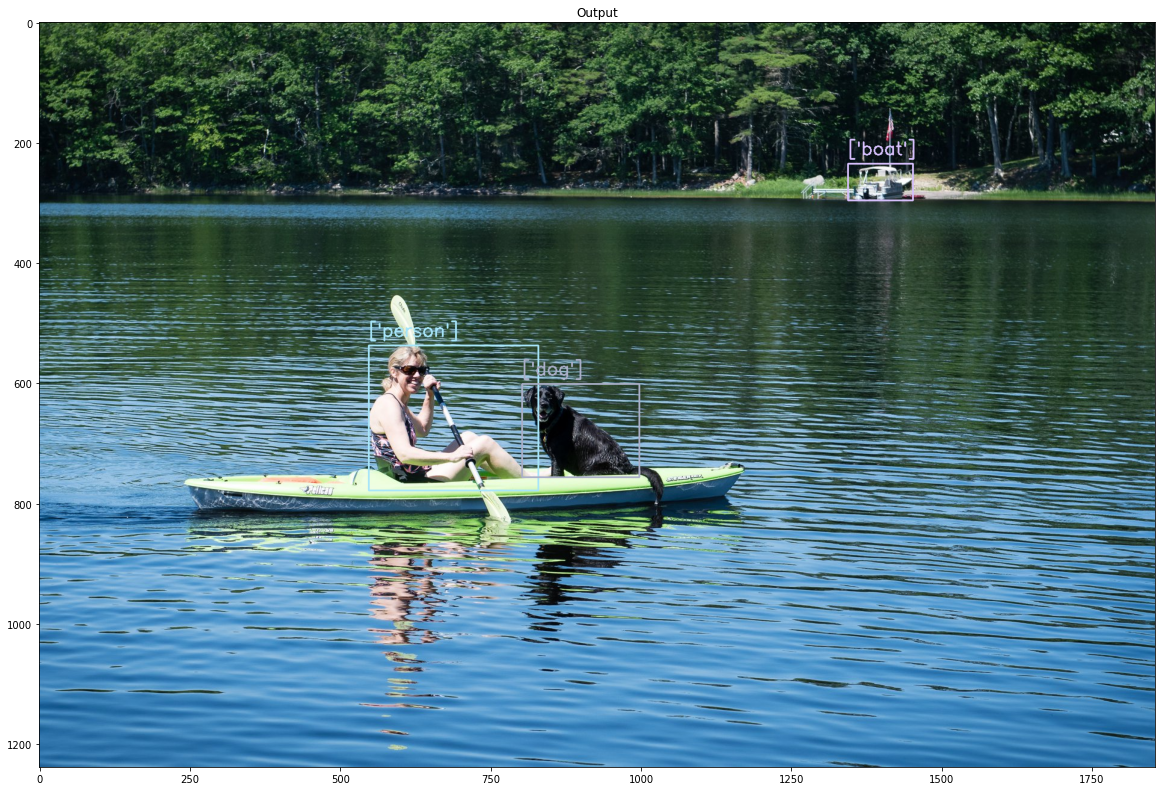

In [15]:
MIN_CONFIDENCE = 0.9

# loop over detected classes in prediction
for i in range(0, len(predictions["boxes"])):
	# extract the confidence (i.e., probability) associated with the
	# prediction
  confidence = predictions["scores"][i]

  # filter out weak predictions by ensuring the confidence is > MIN_CONFIDENCE
  if confidence > MIN_CONFIDENCE:
    idx = int(predictions["labels"][i])
    CLASS = str(CLASSES[idx])
    CONFIDENCE = confidence * 100
    # output the predictions 
    print("CLASS     : {} ({:.2f})%".format(CLASS,CONFIDENCE))
    box = predictions["boxes"][i].tolist()
    # draw the bounding box and label on the image
    #box = detections["boxes"][i].detach().cpu().numpy()
   
    box_list = []
    for num in box:
        box_list.append(int(num))
    
    (startX, startY, endX, endY) = box_list
    print("BOUND BOX : {}".format(box_list))
    cv2.rectangle(orig, (startX, startY), (endX, endY),COLORS[idx], 2)
    
    # Add predicted CLASS text to array
    y = startY - 15 if startY - 15 > 15 else startY + 15
    cv2.putText(orig, CLASS, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 1, COLORS[idx], 2)


# show the output image
display_prediction("Output", orig)